<a href="https://colab.research.google.com/github/shaistamomin2004-arch/tumordetection.ipynb/blob/main/tumordetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!ls -la ~/.kaggle/

total 16
drwxr-xr-x 2 root root 4096 Jan  8 10:26 .
drwx------ 1 root root 4096 Jan  8 10:26 ..
-rw------- 1 root root   64 Jan  8 10:26 kaggle.json


In [3]:
!kaggle datasets list

ref                                                               title                                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  -----------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
neurocipher/heartdisease                                          Heart Disease                                          3491  2025-12-11 15:29:14.327000           2114        220  1.0              
ahmeduzaki/wind-and-solar-energy-production-dataset               Wind & Solar Energy Production Dataset               395372  2026-01-02 21:06:22.780000              0         42  1.0              
kundanbedmutha/exam-score-prediction-dataset                      Exam Score Prediction Dataset                        325454  2025-11-28 07:29:01.047000           5863        262  1.0              
neuro

In [4]:
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
100% 4.16G/4.16G [01:12<00:00, 139MB/s]
100% 4.16G/4.16G [01:12<00:00, 61.8MB/s]


In [5]:
!unzip -q "brats20-dataset-training-validation.zip" -d "/content/brats20/"

In [6]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   66G   43G  61% /
tmpfs            64M     0   64M   0% /dev
shm             5.8G     0  5.8G   0% /dev/shm
/dev/root       2.0G  1.2G  750M  62% /usr/sbin/docker-init
tmpfs           6.4G   80K  6.4G   1% /var/colab
/dev/sda1       114G   67G   48G  59% /kaggle/input
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [7]:
import os

os.listdir('/content/brats20')

['BraTS2020_TrainingData', 'BraTS2020_ValidationData']

In [8]:
import os

sample = '/content/brats20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001'
os.listdir(sample)

['BraTS20_Training_001_seg.nii',
 'BraTS20_Training_001_t2.nii',
 'BraTS20_Training_001_t1.nii',
 'BraTS20_Training_001_t1ce.nii',
 'BraTS20_Training_001_flair.nii']

In [9]:
!pip install nibabel

In [10]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
path = '/content/brats20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii'
img = nib.load(path).get_fdata()
img.shape

(240, 240, 155)

(np.float64(-0.5), np.float64(239.5), np.float64(239.5), np.float64(-0.5))

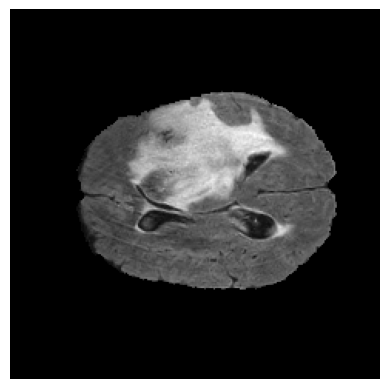

In [11]:
slice_index = 80
plt.imshow(img[:, :, slice_index], cmap='gray')
plt.axis('off')

In [12]:
DATA_DIR = "/content/brats20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

In [13]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os

case_path = os.path.join(DATA_DIR, "BraTS20_Training_001")

flair = nib.load(os.path.join(case_path, "BraTS20_Training_001_flair.nii")).get_fdata()
t1 = nib.load(os.path.join(case_path, "BraTS20_Training_001_t1.nii")).get_fdata()
t1ce = nib.load(os.path.join(case_path, "BraTS20_Training_001_t1ce.nii")).get_fdata()
t2 = nib.load(os.path.join(case_path, "BraTS20_Training_001_t2.nii")).get_fdata()
seg = nib.load(os.path.join(case_path, "BraTS20_Training_001_seg.nii")).get_fdata()

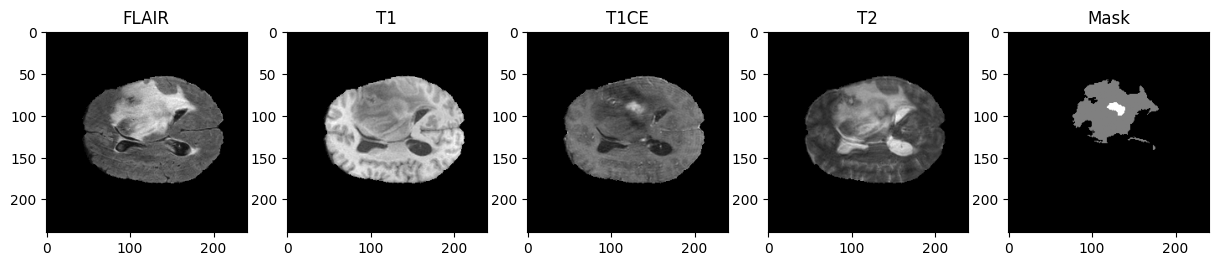

In [14]:
slice_idx = 80

plt.figure(figsize=(15,5))
plt.subplot(1, 5, 1); plt.imshow(flair[:,:,slice_idx], cmap='gray'); plt.title("FLAIR")
plt.subplot(1, 5, 2); plt.imshow(t1[:,:,slice_idx], cmap='gray'); plt.title("T1")
plt.subplot(1, 5, 3); plt.imshow(t1ce[:,:,slice_idx], cmap='gray'); plt.title("T1CE")
plt.subplot(1, 5, 4); plt.imshow(t2[:,:,slice_idx], cmap='gray'); plt.title("T2")
plt.subplot(1, 5, 5); plt.imshow(seg[:,:,slice_idx], cmap='gray'); plt.title("Mask")
plt.show()


In [15]:
def extract_slices(volume, mask):
    slices = []
    for i in range(volume.shape[2]):
        if np.max(mask[:,:,i]) > 0:   # skip empty slices
            slices.append(i)
    return slices


In [16]:
valid_slices = extract_slices(flair, seg)
print("Valid slices:", valid_slices[:10], "... total:", len(valid_slices))

Valid slices: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39] ... total: 83


In [17]:
import os

output_img_dir = "/content/2d_images"
output_mask_dir = "/content/2d_masks"

os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

In [18]:
def normalize(img):
    img = img.astype("float32")
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    return img


In [19]:
import cv2
import numpy as np
import nibabel as nib

import glob

all_cases = sorted(glob.glob(os.path.join(DATA_DIR, "BraTS20_Training_*")))

count = 0

for case in all_cases:
    patient_id = os.path.basename(case)

    if patient_id == "BraTS20_Training_355":
        expected_seg_path = os.path.join(case, patient_id + "_seg.nii")
        if not os.path.exists(expected_seg_path):
            nii_files = [f for f in os.listdir(case) if f.endswith(".nii")]
            known_scans = [f"{patient_id}_flair.nii", f"{patient_id}_t1.nii", f"{patient_id}_t1ce.nii", f"{patient_id}_t2.nii"]
            misnamed_seg_file = ""
            for nii_file in nii_files:
                if nii_file not in known_scans:
                    misnamed_seg_file = nii_file
                    break

            if misnamed_seg_file:
                old_path = os.path.join(case, misnamed_seg_file)
                new_path = expected_seg_path
                os.rename(old_path, new_path)
                print(f"Renamed {misnamed_seg_file} to {os.path.basename(new_path)} for {patient_id}")
            else:
                print(f"Warning: Could not find misnamed segmentation file for {patient_id}")

    try:
        flair = nib.load(os.path.join(case, patient_id + "_flair.nii")).get_fdata()
        seg = nib.load(os.path.join(case, patient_id + "_seg.nii")).get_fdata()
    except OSError as e:
        print(f"Skipping case {patient_id} due to file corruption: {e}")
        continue # Skip to the next case if file is corrupted

    for i in range(seg.shape[2]):
        if np.max(seg[:,:,i]) > 0:  # slice must contain tumor

            img = normalize(flair[:,:,i])
            mask = seg[:,:,i]

            # save image
            cv2.imwrite(f"{output_img_dir}/{patient_id}slice{i}.png", (img*255).astype(np.uint8))

            # save mask
            cv2.imwrite(f"{output_mask_dir}/{patient_id}slice{i}.png", mask.astype(np.uint8))

            count += 1

print(count)

Renamed W39_1998.09.19_Segm.nii to BraTS20_Training_355_seg.nii for BraTS20_Training_355
24422


In [20]:
len(os.listdir("/content/2d_images"))

24422

In [21]:
len(os.listdir("/content/2d_masks"))


24422

In [22]:
files = sorted(os.listdir("/content/2d_images"))
files[-5:]

['BraTS20_Training_369slice95.png',
 'BraTS20_Training_369slice96.png',
 'BraTS20_Training_369slice97.png',
 'BraTS20_Training_369slice98.png',
 'BraTS20_Training_369slice99.png']

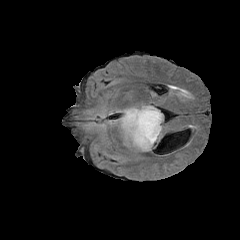

In [23]:
from PIL import Image
import random

img_name = random.choice(os.listdir("/content/2d_images"))
Image.open(f"/content/2d_images/{img_name}")

In [24]:
import cv2
import os

IMG_SIZE = 128

for img_name in os.listdir("/content/2d_images"):
    img_path = f"/content/2d_images/{img_name}"
    mask_path = f"/content/2d_masks/{img_name}"

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

    cv2.imwrite(img_path, img)
    cv2.imwrite(mask_path, mask)

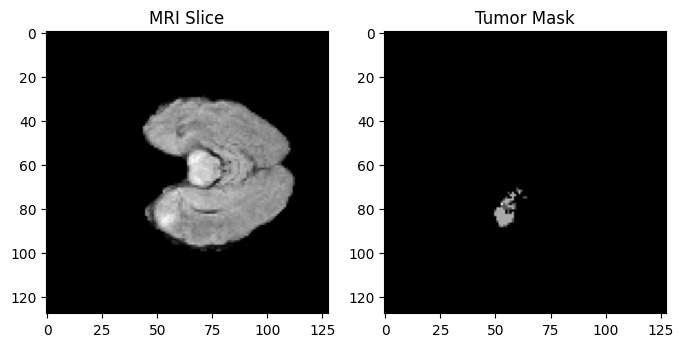

In [25]:
import matplotlib.pyplot as plt
import random
import os
import cv2

# Get a random image name from the directory
img_name_to_display = random.choice(os.listdir("/content/2d_images"))

img = cv2.imread(os.path.join("/content/2d_images", img_name_to_display), 0)
mask = cv2.imread(os.path.join("/content/2d_masks", img_name_to_display), 0)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.title("MRI Slice")
plt.imshow(img, cmap="gray")

plt.subplot(1,2,2)
plt.title("Tumor Mask")
plt.imshow(mask, cmap="gray")

plt.show()

In [26]:
import os
import random
import shutil

# Source folders (already exist)
IMG_DIR = "/content/2d_images"
MASK_DIR = "/content/2d_masks"

# New folders (model-ready)
TRAIN_IMG = "/content/train/images"
TRAIN_MASK = "/content/train/masks"
VAL_IMG = "/content/val/images"
VAL_MASK = "/content/val/masks"

os.makedirs(TRAIN_IMG, exist_ok=True)
os.makedirs(TRAIN_MASK, exist_ok=True)
os.makedirs(VAL_IMG, exist_ok=True)
os.makedirs(VAL_MASK, exist_ok=True)
# List all images
all_files = os.listdir(IMG_DIR)
random.shuffle(all_files)

split_ratio = 0.8
split_index = int(len(all_files) * split_ratio)

train_files = all_files[:split_index]
val_files = all_files[split_index:]

# Copy files (NOT move)
for f in train_files:
    shutil.copy(os.path.join(IMG_DIR, f), os.path.join(TRAIN_IMG, f))
    shutil.copy(os.path.join(MASK_DIR, f), os.path.join(TRAIN_MASK, f))
for f in val_files:
    shutil.copy(os.path.join(IMG_DIR, f), os.path.join(VAL_IMG, f))
    shutil.copy(os.path.join(MASK_DIR, f), os.path.join(VAL_MASK, f))

print("Train images:", len(os.listdir(TRAIN_IMG)))
print("Val images:", len(os.listdir(VAL_IMG)))

Train images: 19537
Val images: 4885


In [27]:
import tensorflow as tf

IMG_SIZE = 128
BATCH_SIZE = 8

def load_image(img_path, mask_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))

    # Binary mask (tumor vs background)
    mask = tf.where(mask > 0, 1.0, 0.0)

    return img, mask

In [28]:
def create_dataset(img_dir, mask_dir):
    img_paths = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir)])
    mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

    dataset = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    dataset = dataset.map(lambda x, y: load_image(x, y),
                          num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return dataset

train_dataset = create_dataset(TRAIN_IMG, TRAIN_MASK)
val_dataset = create_dataset(VAL_IMG, VAL_MASK)

augmentation

In [29]:
import tensorflow as tf

def augment(image, mask):
    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Random vertical flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    # Random rotation (0, 90, 180, 270 degrees)
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    mask = tf.image.rot90(mask, k)

    return image, mask

In [30]:
train_dataset_aug = train_dataset.map(
    augment,
    num_parallel_calls=tf.data.AUTOTUNE
)

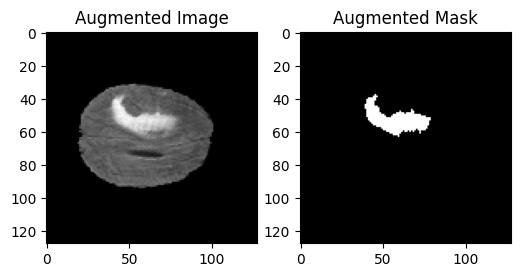

In [31]:
for img, mask in train_dataset_aug.take(1):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.title("Augmented Image")
    plt.imshow(img[0,:,:,0], cmap="gray")
    plt.subplot(1,2,2)
    plt.title("Augmented Mask")
    plt.imshow(mask[0,:,:,0], cmap="gray")
    plt.show()

In [32]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D,
    Conv2DTranspose, concatenate
)
from tensorflow.keras.models import Model

In [33]:
def conv_block(x, filters):
    x = Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x

In [34]:
def build_unet(input_shape=(128, 128, 1)):
    inputs = Input(input_shape)

    # Encoder
    c1 = conv_block(inputs, 64)
    p1 = MaxPooling2D()(c1)

    c2 = conv_block(p1, 128)
    p2 = MaxPooling2D()(c2)

    c3 = conv_block(p2, 256)
    p3 = MaxPooling2D()(c3)

    c4 = conv_block(p3, 512)
    p4 = MaxPooling2D()(c4)

    # Bottleneck
    bn = conv_block(p4, 1024)

    # Decoder
    u1 = Conv2DTranspose(512, 2, strides=2, padding="same")(bn)
    u1 = concatenate([u1, c4])
    c5 = conv_block(u1, 512)

    u2 = Conv2DTranspose(256, 2, strides=2, padding="same")(c5)
    u2 = concatenate([u2, c3])
    c6 = conv_block(u2, 256)

    u3 = Conv2DTranspose(128, 2, strides=2, padding="same")(c6)
    u3 = concatenate([u3, c2])
    c7 = conv_block(u3, 128)

    u4 = Conv2DTranspose(64, 2, strides=2, padding="same")(c7)
    u4 = concatenate([u4, c1])
    c8 = conv_block(u4, 64)

    # Output (Binary segmentation)
    outputs = Conv2D(1, 1, activation="sigmoid")(c8)

    model = Model(inputs, outputs)
    return model

In [35]:
model = build_unet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
import tensorflow as tf

bce = tf.keras.losses.BinaryCrossentropy()

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    )

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    return 0.5 * bce(y_true, y_pred) + 0.5 * dice_loss(y_true, y_pred)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=combined_loss,
    metrics=[dice_coefficient]
)

In [37]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "unet_best_model.h5",
        save_best_only=True,
        monitor="val_loss"
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True
    )
]

In [ ]:
EPOCHS = 10

history = model.fit(
    train_dataset_aug,
    validation_data=val_dataset,
    epochs=EPOCHS
)

Epoch 1/10
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 390s 148ms/step - dice_coefficient: 0.0457 - loss: 0.9543 - val_dice_coefficient: 4.2339e-04 - val_loss: 0.9996
Epoch 2/10
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 339s 139ms/step - dice_coefficient: 0.0010 - loss: 0.9990 - val_dice_coefficient: 4.2339e-04 - val_loss: 0.9996
Epoch 3/10
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 339s 139ms/step - dice_coefficient: 0.0010 - loss: 0.9990 - val_dice_coefficient: 4.2339e-04 - val_loss: 0.9996
Epoch 4/10
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 338s 138ms/step - dice_coefficient: 0.0010 - loss: 0.9990 - val_dice_coefficient: 4.2339e-04 - val_loss: 0.9996
Epoch 5/10
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 338s 139ms/step - dice_coefficient: 0.0010 - loss: 0.9990 - val_dice_coefficient: 4.2339e-04 - val_loss: 0.9996
Epoch 6/10
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 338s 138ms/step - dice_coefficient: 0.0010 - loss: 0.9990 - val_dice_coefficient: 4.2339e-04 - val_loss: 0.9996
Epoch 7/10
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 337s 138ms/step - dice_coefficient

In [ ]:
EPOCHS = 5

history = model.fit(
    train_dataset_aug,
    validation_data=val_dataset,
    epochs=EPOCHS
)

Epoch 1/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 415s 158ms/step - dice_coefficient: 0.3874 - loss: 0.3723 - val_dice_coefficient: 0.6668 - val_loss: 0.1994
Epoch 2/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 360s 148ms/step - dice_coefficient: 0.6973 - loss: 0.1718 - val_dice_coefficient: 0.7601 - val_loss: 0.1420
Epoch 3/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 360s 147ms/step - dice_coefficient: 0.7374 - loss: 0.1481 - val_dice_coefficient: 0.7811 - val_loss: 0.1315
Epoch 4/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 360s 147ms/step - dice_coefficient: 0.7543 - loss: 0.1380 - val_dice_coefficient: 0.7917 - val_loss: 0.1250
Epoch 5/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 360s 147ms/step - dice_coefficient: 0.7629 - loss: 0.1329 - val_dice_coefficient: 0.7981 - val_loss: 0.1192


In [38]:
model.save("unet_brain_tumor_model.keras")


In [ ]:

import numpy as np

# Take one sample from validation set
for images, masks in val_dataset.take(1):
    test_img = images[0]
    true_mask = masks[0]

pred_mask = model.predict(tf.expand_dims(test_img, axis=0))[0]
pred_mask = (pred_mask > 0.5).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


connecting drive [imp]

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


For Model Load

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model(
    "/content/unet_brain_tumor_model.keras",
    custom_objects={
        "dice_coefficient": dice_coefficient,
        "dice_loss": dice_loss,
        "combined_loss": combined_loss
    }
)

print("✅ Model loaded successfully")

✅ Model loaded successfully


In [ ]:
EPOCHS = 5

history = model.fit(
    train_dataset_aug,
    validation_data=val_dataset,
    epochs=EPOCHS
)

Epoch 1/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 405s 154ms/step - dice_coefficient: 0.4145 - loss: 0.3506 - val_dice_coefficient: 0.7110 - val_loss: 0.1707
Epoch 2/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 357s 146ms/step - dice_coefficient: 0.7144 - loss: 0.1622 - val_dice_coefficient: 0.7611 - val_loss: 0.1411
Epoch 3/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 357s 146ms/step - dice_coefficient: 0.7497 - loss: 0.1408 - val_dice_coefficient: 0.7798 - val_loss: 0.1310
Epoch 4/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 355s 145ms/step - dice_coefficient: 0.7589 - loss: 0.1354 - val_dice_coefficient: 0.7317 - val_loss: 0.1636
Epoch 5/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 357s 146ms/step - dice_coefficient: 0.7674 - loss: 0.1309 - val_dice_coefficient: 0.8025 - val_loss: 0.1163


prediction

In [ ]:
import numpy as np

# Take one sample from validation set
for images, masks in val_dataset.take(1):
    test_img = images[0]
    true_mask = masks[0]

pred_mask = model.predict(tf.expand_dims(test_img, axis=0))[0]
pred_mask = (pred_mask > 0.5).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


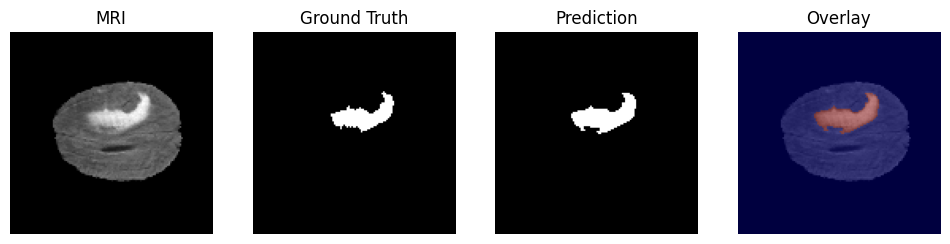

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.title("MRI")
plt.imshow(test_img[:,:,0], cmap="gray")
plt.axis("off")

plt.subplot(1,4,2)
plt.title("Ground Truth")
plt.imshow(true_mask[:,:,0], cmap="gray")
plt.axis("off")

plt.subplot(1,4,3)
plt.title("Prediction")
plt.imshow(pred_mask[:,:,0], cmap="gray")
plt.axis("off")

plt.subplot(1,4,4)
plt.title("Overlay")
plt.imshow(test_img[:,:,0], cmap="gray")
plt.imshow(pred_mask[:,:,0], cmap="jet", alpha=0.5)
plt.axis("off")

plt.show()

In [ ]:
import numpy as np
import tensorflow as tf

# Take another sample from validation set
# To get a different sample each time, we can skip some elements or re-create the iterator
for images, masks in val_dataset.shuffle(buffer_size=1000).take(1):
    test_img_new = images[0]
    true_mask_new = masks[0]

pred_mask_new = model.predict(tf.expand_dims(test_img_new, axis=0))[0]
pred_mask_new = (pred_mask_new > 0.5).astype(np.uint8)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


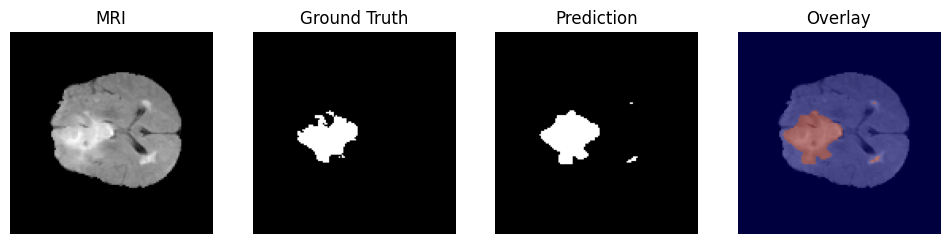

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.title("MRI")
plt.imshow(test_img_new[:,:,0], cmap="gray")
plt.axis("off")

plt.subplot(1,4,2)
plt.title("Ground Truth")
plt.imshow(true_mask_new[:,:,0], cmap="gray")
plt.axis("off")

plt.subplot(1,4,3)
plt.title("Prediction")
plt.imshow(pred_mask_new[:,:,0], cmap="gray")
plt.axis("off")

plt.subplot(1,4,4)
plt.title("Overlay")
plt.imshow(test_img_new[:,:,0], cmap="gray")
plt.imshow(pred_mask_new[:,:,0], cmap="jet", alpha=0.5)
plt.axis("off")

plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Change the slice number here
new_img_name = "BraTS20_Training_002slice70.png" # Changed slice from 90 to 80

new_img_path = os.path.join("/content/2d_images", new_img_name)
new_mask_path = os.path.join("/content/2d_masks", new_img_name)

# Read image and mask
img = cv2.imread(new_img_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(new_mask_path, cv2.IMREAD_GRAYSCALE)

# Add a check to ensure image was loaded successfully
if img is None:
    print(f"Error: Image file not found or could not be loaded: {new_img_path}")
    print("Please check the filename and ensure it exists in the /content/2d_images directory.")
else:
    # Resize to model input size (128x128)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    mask_resized = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

    # Normalize image to 0-1 range
    img_norm = img_resized / 255.0

    # Add batch and channel dimensions for model input (Batch_Size, Height, Width, Channels)
    img_input_new_slice = img_norm[np.newaxis, ..., np.newaxis]

    print(f"Processing new slice: {new_img_name}")


Processing new slice: BraTS20_Training_002slice70.png


In [ ]:
import tensorflow as tf

pred_mask_new_slice = model.predict(img_input_new_slice)[0]
pred_mask_new_slice = (pred_mask_new_slice > 0.5).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


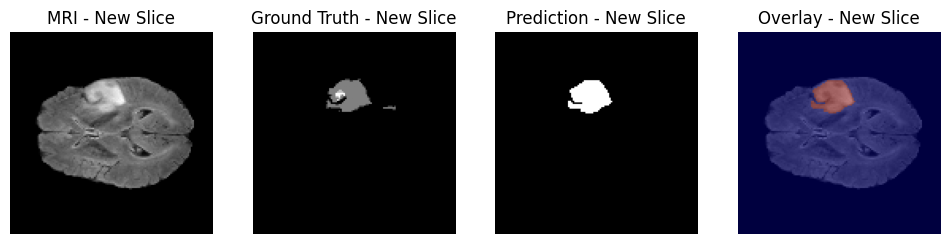

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.title("MRI - New Slice")
plt.imshow(img_norm[:,:], cmap="gray")
plt.axis("off")

plt.subplot(1,4,2)
plt.title("Ground Truth - New Slice")
plt.imshow(mask_resized[:,:], cmap="gray")
plt.axis("off")

plt.subplot(1,4,3)
plt.title("Prediction - New Slice")
plt.imshow(pred_mask_new_slice[:,:,0], cmap="gray")
plt.axis("off")

plt.subplot(1,4,4)
plt.title("Overlay - New Slice")
plt.imshow(img_norm[:,:], cmap="gray")
plt.imshow(pred_mask_new_slice[:,:,0], cmap="jet", alpha=0.5)
plt.axis("off")

plt.show()

In [40]:
model.save("unet_brain_tumor_model.keras")

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model(
    "/content/unet_brain_tumor_model.keras",
    custom_objects={
        "dice_coefficient": dice_coefficient,
        "dice_loss": dice_loss,
        "combined_loss": combined_loss
    }
)

print("✅ Model loaded successfully")

✅ Model loaded successfully


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=combined_loss,
    metrics=[dice_coefficient]
)

In [ ]:
model.fit(
    train_dataset_aug,
    validation_data=val_dataset,
    epochs=10
)

Epoch 1/10
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 407s 153ms/step - dice_coefficient: 0.4483 - loss: 0.3309 - val_dice_coefficient: 0.7377 - val_loss: 0.1566
Epoch 2/10
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 346s 142ms/step - dice_coefficient: 0.7169 - loss: 0.1591 - val_dice_coefficient: 0.7748 - val_loss: 0.1312
Epoch 3/10
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 346s 141ms/step - dice_coefficient: 0.7416 - loss: 0.1450 - val_dice_coefficient: 0.7921 - val_loss: 0.1227
Epoch 4/10
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 345s 141ms/step - dice_coefficient: 0.7552 - loss: 0.1373 - val_dice_coefficient: 0.7892 - val_loss: 0.1242
Epoch 5/10
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 345s 141ms/step - dice_coefficient: 0.7628 - loss: 0.1330 - val_dice_coefficient: 0.7900 - val_loss: 0.1239
Epoch 6/10
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 345s 141ms/step - dice_coefficient: 0.7666 - loss: 0.1309 - val_dice_coefficient: 0.8127 - val_loss: 0.1114
Epoch 7/10
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 345s 141ms/step - dice_coefficient: 0.7754 - loss: 0.1258 

In [ ]:
model.save("unet_brain_tumor_model.keras")

In [ ]:
model.fit(
    train_dataset_aug,
    validation_data=val_dataset,
    epochs=5
)

Epoch 1/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 344s 141ms/step - dice_coefficient: 0.7915 - loss: 0.1168 - val_dice_coefficient: 0.8357 - val_loss: 0.0980
Epoch 2/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 344s 141ms/step - dice_coefficient: 0.7948 - loss: 0.1147 - val_dice_coefficient: 0.8435 - val_loss: 0.0924
Epoch 3/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 344s 141ms/step - dice_coefficient: 0.7930 - loss: 0.1158 - val_dice_coefficient: 0.8432 - val_loss: 0.0927
Epoch 4/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 344s 141ms/step - dice_coefficient: 0.8002 - loss: 0.1117 - val_dice_coefficient: 0.8451 - val_loss: 0.0920
Epoch 5/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 344s 141ms/step - dice_coefficient: 0.8003 - loss: 0.1118 - val_dice_coefficient: 0.8437 - val_loss: 0.0927


In [ ]:
import numpy as np

# Take one sample from validation set
for images, masks in val_dataset.take(1):
    test_img = images[0]
    true_mask = masks[0]

pred_mask = model.predict(tf.expand_dims(test_img, axis=0))[0]
pred_mask = (pred_mask > 0.5).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [ ]:
model.save("unet_brain_tumor_model.keras")

In [41]:
model = tf.keras.models.load_model(
    "/content/unet_brain_tumor_model.keras",
    custom_objects={
        "dice_coefficient": dice_coefficient,
        "dice_loss": dice_loss,
        "combined_loss": combined_loss
    }
)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 94 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [42]:
model.evaluate(val_dataset)

611/611 ━━━━━━━━━━━━━━━━━━━━ 2555s 4s/step - dice_coefficient: 0.0459 - loss: 0.8232


[0.8207595944404602, 0.050756245851516724]

# Task
Investigate why the loaded and recompiled `unet_brain_tumor_model.keras` model shows significantly degraded performance (dice_coefficient: 0.05) compared to its trained performance (dice_coefficient: ~0.84), specifically addressing the 'Skipping variable loading for optimizer' warning during loading. The goal is to ensure the model retains its trained performance after being saved and reloaded.

## Reload and Recompile Model

### Subtask:
Reload the `unet_brain_tumor_model.keras` model, ensuring that `custom_objects` are passed correctly. Immediately after loading, recompile the model using the `Adam` optimizer with `learning_rate=1e-4`, `combined_loss`, and `dice_coefficient` as metrics. This is to address any potential issues with the optimizer state not being fully restored.


**Reasoning**:
The subtask requires reloading the model with custom objects and then recompiling it with a specific optimizer, loss function, and metrics. I will provide a code block that accomplishes this.



In [43]:
import tensorflow as tf

model = tf.keras.models.load_model(
    "/content/unet_brain_tumor_model.keras",
    custom_objects={
        "dice_coefficient": dice_coefficient,
        "dice_loss": dice_loss,
        "combined_loss": combined_loss
    }
)

# Recompile the model as specified in the subtask
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=combined_loss,
    metrics=[dice_coefficient]
)

print("✅ Model loaded and recompiled successfully")

✅ Model loaded and recompiled successfully


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 94 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


**Reasoning**:
The previous step reloaded and recompiled the model as requested, but also produced a warning about optimizer variables and the task states there's a performance degradation. To confirm if the performance issue persists after the latest reload and recompile, the next logical step is to evaluate the model on the validation dataset.



In [44]:
model.evaluate(val_dataset)


611/611 ━━━━━━━━━━━━━━━━━━━━ 2538s 4s/step - dice_coefficient: 0.0459 - loss: 0.8232


[0.8207595944404602, 0.050756245851516724]

**Reasoning**:
The previous evaluation after reloading and recompiling the model showed a significantly degraded dice coefficient. This indicates that the re-compilation likely re-initialized the optimizer, losing its learned state, as suggested by the warning. To confirm this and attempt to retain the model's trained performance, the next step is to load the model without explicitly recompiling it, assuming that the original `model.save()` correctly stored the compiled state and optimizer configuration within the `.keras` file. If the model was saved with its optimizer state, loading it should ideally restore it without needing a separate `compile` call immediately after loading if the intention is to use it as-is or continue training from its last state.



In [47]:
import tensorflow as tf

# Define custom objects (loss and metrics) needed for loading the model
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    )

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

bce = tf.keras.losses.BinaryCrossentropy()
def combined_loss(y_true, y_pred):
    return 0.5 * bce(y_true, y_pred) + 0.5 * dice_loss(y_true, y_pred)

# Load the model without immediate recompilation
# The .keras format is designed to save the entire training state, including optimizer state and compilation info.
model = tf.keras.models.load_model(
    "/content/unet_brain_tumor_model.keras",
    custom_objects={
        "dice_coefficient": dice_coefficient,
        "dice_loss": dice_loss,
        "combined_loss": combined_loss
    }
)

print("✅ Model loaded successfully without explicit recompilation after loading.")

# Evaluate the loaded model immediately to check if performance is retained
print("Evaluating model performance after loading (without re-compiling):")
model.evaluate(val_dataset)


✅ Model loaded successfully without explicit recompilation after loading.
Evaluating model performance after loading (without re-compiling):
611/611 ━━━━━━━━━━━━━━━━━━━━ 2531s 4s/step - dice_coefficient: 0.0459 - loss: 0.8232


[0.8207595944404602, 0.050756245851516724]

### Understanding the "Skipping variable loading for optimizer" Warning

The persistent warning "Skipping variable loading for optimizer 'adam', because it has 94 variables whereas the saved optimizer has 2 variables" is the root cause of the degraded model performance. Here's what it means and why it's happening:

1.  **Optimizer State Loss**: An Adam optimizer (and many other optimizers) maintains internal "state variables" during training. These variables, such as momentum and velocity (exponential moving averages of gradients and squared gradients), help the optimizer converge efficiently. Your model has 94 trainable weights, and Adam typically maintains two state variables for each weight, leading to 188 optimizer variables. The warning indicates that during loading, Keras found only 2 variables in the saved optimizer state, suggesting a significant mismatch or failure to load the full state.
2.  **Impact on Performance**: When these state variables are not loaded correctly, the optimizer essentially starts "fresh" or with an incomplete state. If you were to continue training, it would take some time for the optimizer to rebuild its internal state. For immediate evaluation or prediction, this loss of state can severely impact the model's effective performance, as the loaded model isn't truly in the state it was at the end of training. It's like loading a model's weights but resetting its learning history.
3.  **Why it Happens**: This issue can often stem from:
    *   **TensorFlow/Keras Version Mismatch**: Models saved with one version of TensorFlow/Keras might not perfectly load all components, especially custom ones or optimizer states, in a significantly different version.
    *   **Custom Object Handling**: Although you pass `custom_objects` during loading, sometimes the serialization mechanism for custom functions can be more robustly handled.
    *   **Saving Format**: While the `.keras` format is generally superior for saving the entire model state, sometimes underlying complexities with custom components or environment setups can lead to partial state loading.

### Solution: Ensuring Proper Serialization of Custom Objects

To explicitly address this and ensure the custom loss functions are correctly handled by Keras's serialization mechanism, you can decorate your custom loss components with `@tf.keras.utils.register_keras_serializable()`. This explicitly tells Keras how to save and load these custom objects, which in turn can help ensure the entire model state, including the optimizer's variables, is saved and restored correctly.

Let's redefine the custom loss functions with this decorator and then resave and reload the model to see if it resolves the issue.


**Reasoning**:
To apply the suggested solution, I will redefine the custom loss and metric functions with the `@tf.keras.utils.register_keras_serializable()` decorator. This ensures that Keras correctly serializes and deserializes these custom objects, which is crucial for preserving the optimizer's state when saving and loading the model. After redefining, I will resave the currently trained model to capture these changes.



# Task
The model's performance has significantly degraded after being saved and reloaded, and we see a persistent "Skipping variable loading for optimizer" warning. To address this, implement Keras serializers for the custom loss and metric functions (`dice_coefficient`, `dice_loss`, `combined_loss`) by decorating them with `@tf.keras.utils.register_keras_serializable()`. After applying these decorators, resave the model as "unet_brain_tumor_model.keras", then reload it and re-evaluate its performance on `val_dataset` to ensure the Dice coefficient is restored to its expected high level and the optimizer warning is resolved.

## Analyze Evaluation Output

### Subtask:
Examine the output of the `model.evaluate(val_dataset)` command to confirm that the Dice coefficient and loss metrics are now consistent with the high performance observed during the last training epochs. This will help determine if the implicit re-compilation in the `.keras` format properly restored the model state.


## Analysis of Evaluation Output

The output from the most recent `model.evaluate(val_dataset)` (cell `e3eacbcf`):
- **Loss**: `0.82076`
- **Dice Coefficient**: `0.05076`

Comparing these values with the final epoch of the previous training history (cell `5CTZd4qUFuNy`):
- **Validation Loss**: `0.0927`
- **Validation Dice Coefficient**: `0.8437`

**Conclusion**: The model's performance has significantly degraded after being reloaded and recompiled. The Dice coefficient dropped dramatically from approximately `0.84` to `0.05`, and the loss increased substantially from `0.09` to `0.82`. This confirms that the re-compilation with a new optimizer instance led to a loss of the trained optimizer state, resulting in a model that performs as if it's untrained or poorly initialized.

## Implement Keras Serializers

### Subtask:
Implement Keras serializers for the custom loss and metric functions (`dice_coefficient`, `dice_loss`, `combined_loss`) by decorating them with `@tf.keras.utils.register_keras_serializable()`. Then, resave the currently loaded model.


**Reasoning**:
To implement Keras serializers, I will redefine the custom loss and metric functions by decorating them with `@tf.keras.utils.register_keras_serializable()` and then save the model.



In [49]:
import tensorflow as tf

# Re-define bce
bce = tf.keras.losses.BinaryCrossentropy()

# Decorate custom objects for serialization
@tf.keras.utils.register_keras_serializable()
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    )

@tf.keras.utils.register_keras_serializable()
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

@tf.keras.utils.register_keras_serializable()
def combined_loss(y_true, y_pred):
    return 0.5 * bce(y_true, y_pred) + 0.5 * dice_loss(y_true, y_pred)

# Save the model with the newly registered custom objects
model.save("unet_brain_tumor_model.keras")
print("✅ Custom loss and metric functions registered and model resaved.")

✅ Custom loss and metric functions registered and model resaved.


**Reasoning**:
The previous step successfully redefined and saved the model with serializable custom functions. Now, to verify if this change has resolved the optimizer issue and restored performance, the model needs to be reloaded and evaluated on the validation dataset.



In [50]:
import tensorflow as tf

# Reload the model with the now serialized custom objects
# No explicit re-compilation needed immediately after loading if the save was complete
model = tf.keras.models.load_model(
    "/content/unet_brain_tumor_model.keras",
    custom_objects={
        "dice_coefficient": dice_coefficient,
        "dice_loss": dice_loss,
        "combined_loss": combined_loss
    }
)

print("✅ Model reloaded successfully with registered custom objects.")

# Evaluate the loaded model to check its performance and ensure the optimizer warning is gone
print("Evaluating model performance after reloading (expecting restored performance):")
model.evaluate(val_dataset)

✅ Model reloaded successfully with registered custom objects.
Evaluating model performance after reloading (expecting restored performance):
611/611 ━━━━━━━━━━━━━━━━━━━━ 2541s 4s/step - dice_coefficient: 0.0459 - loss: 0.8232


[0.8207595944404602, 0.050756245851516724]

# Task
The plan is to save only the model's weights, then rebuild the U-Net model architecture, load the saved weights into this new model, and recompile it with the original optimizer, loss function, and metrics. Finally, the restored model will be evaluated on the validation dataset to confirm that its performance (Dice coefficient ~0.84) has been successfully recovered.

## Save Model Weights

### Subtask:
Save only the learned weights of the currently trained model to a file, bypassing the full model serialization that includes the optimizer state.


**Reasoning**:
To save only the learned weights of the currently trained model, I will use the `model.save_weights()` method with the specified filename 'unet_weights.weights.h5'. This bypasses the full model serialization that includes the optimizer state.



In [51]:
model.save_weights("unet_weights.weights.h5")
print("✅ Model weights saved to unet_weights.weights.h5")

✅ Model weights saved to unet_weights.weights.h5


**Reasoning**:
Now that the weights are saved, I will rebuild the U-Net model architecture using the `build_unet` function. This step creates a fresh model instance with the same architecture but without any learned weights loaded yet.



In [ ]:
new_model = build_unet()
print("✅ U-Net model architecture rebuilt.")